# ENGSCI205 - Engineering Machine Learning
## Neural models

This notebook introduces some basic ways to build and use neural network models for **image classification**.

Here, we will look at:

- Implementing a simple digit classifier neural network.
- Implementing a more sophisticated *convolutional neural network* classifer
- Finally, either implementing a landmark image classifier neural network, LeNet5, or *your own choice* of neural network to beat the simple classifer network.
---


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary

## Note on GPUs

In this, fitting the models **might take some time** as we're going to work with a large dataset. **Please consider using a GPU runtime** to accelerate the computations.

Note: executing code while using a GPU runtime does not automatically mean that the GPU is acutally being used. **To use torch in GPU mode**, we can create PyTorch 'device object' using **torch.device** that will represent a GPU if available. We can then 'move' (copy) a tensor $A$ say to this device *when needed* using **A.to.(device)**.

In [34]:
# create GPU device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MNIST

Let's load the MNIST dataset - a dataset consisting of $28 \times 28$ images of hand-written digits. The hand writings were taken from the American Census Bureau employees and high-school students. The training dataset consists of 60000 images (with the corresponding labels), and the testing dataset consists of 10000 images (also with labels). You can read more about the dataset on the [Yann LeCun's website](https://yann.lecun.com/exdb/mnist/).

In [35]:
transform = transforms.ToTensor()
# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True) # ANSWER

Create data loaders for the training and test datasets. Use a batch size of 32.

In [36]:
# Data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True) # ANSER
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True) # ANSWER

Plot 10 examples from the training dataset with its labels by **iterating over the train\_dataset loader**.

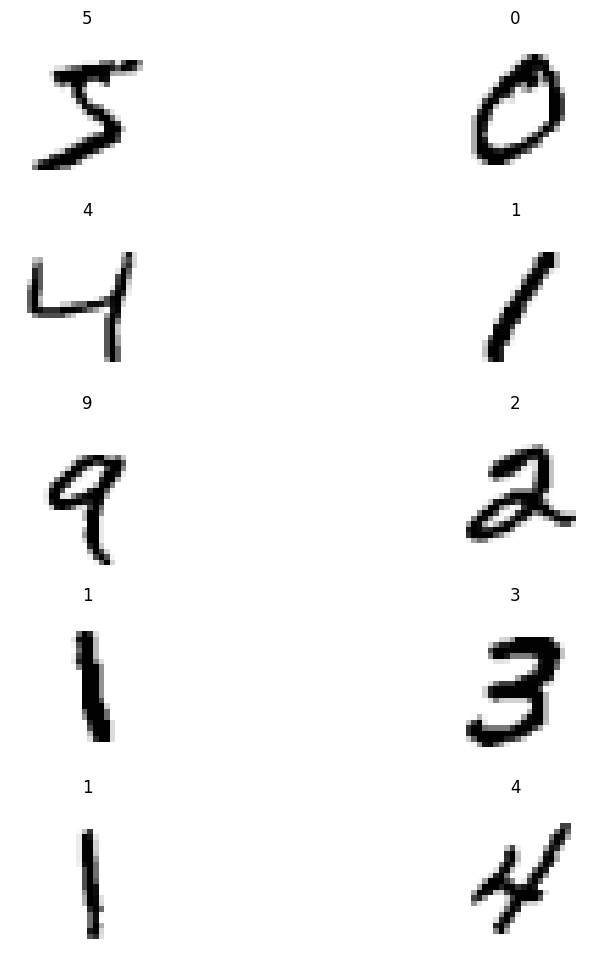

In [37]:
plt.figure(figsize=(10,10))
for i in range(10):
  img, label = train_dataset[i]

  plt.subplot(5,2, i+1)
  plt.title(str(label))
  plt.tight_layout()
  plt.axis('off')
  plt.imshow(torch.permute(img,[1,2,0]), cmap='binary')

plt.show()

Now, we will construct the same simple multi-layer neural network you have seen in the lecture.

Add the required layers with the corresponding parameters.

Note: Use **LogSoftmax** for the last layer rather than Softmax.

If you want to use GPU runtime for training your model you will need to call **yourmodelname = yourmodelname.to(device)** after initialising the model.

In [38]:
num_classes = 10 # For MNIST dataset
simplenet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
    nn.LogSoftmax(dim=1)
    )

simplenet = simplenet.to(device)

For the consistency in results, let's use the **negative log likelihood loss, NLLLoss**, as the loss function, **SGD** as the optimizer, **0.001** as the learning rate, **10** as the number of epochs.

Create the loss function (criterion) and optimiser.

In [39]:
# Loss function and optimizer
criterion = nn.NLLLoss() # ANSWER
optimizer = optim.SGD(simplenet.parameters(), lr=0.001) # ANSWER
num_epochs = 10

# simple lists for storing results as we go
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

## Implementing train() and test() functions

Here we will implement implement **train()** and **test()** functions that will be called **later** within a loop over epochs. The train and test functions themselves will **loop over minibatches** for a fixed partition into minibatches, given by train\_loader and test\_loader, associated with a given epoch.

Both functions should take model name and the epoch number as an input.

**Notes**

- In class we only looked at a very simple neural network. As we start to look at more sophisticated models, it is good to change the 'mode' of the model by calling **model.train()** before running training, and **model.eval()** when evaluating the model for fixed parameters. Briefly, these are methods adjust the behavior of certain more complex layers like **'dropout'** and **'batch normalisation'** layers that work **differently during training and evaluation**. For now, just think of them as signposting what you're doing!

- The training function should also calculate the **loss and the accuracy after each epoch**. To calculate an average loss over an epoch, you will need to **accumulate the minibatch losses during each epoch**. If we divide this by the length of the train loader (i.e. number of minibatches) we get the per-minibatch loss for the given epoch. We divide by the training dataset size we get the per-example loss for the epoch (assuming all minibatches are the same size). This latter quantity allows fairer comparison to the test loss as the training and test sets are different sizes.

- The lecture notes originally just printed the loss of the last minibatch for each epoch, rather than the total or average loss for the epoch. This was lazy and has now been updated in the course notes on Canvas!

- If you want to use GPU runtime, you will need to call .to(device) on the data and labels/targets tensors.

## Implementing the train function

Complete the following train(function).

In [40]:
def train(model, epoch):
    model.train()
    epoch_loss = 0
    correct_pred = 0
    total_pred = 0
    for mb_inputs, mb_targets in train_loader:
        # zero gradients
        optimizer.zero_grad()

        # send to gpu
        mb_inputs, mb_targets = mb_inputs.to(device), mb_targets.to(device)

        # make predictions
        outputs = model(mb_inputs)

        # evaluate loss
        loss = criterion(outputs, mb_targets)

        # compute gradients
        loss.backward()

        # take optimiser step
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

        # Calculate the accuracy
        _, preds = torch.max(outputs, 1)
        correct_pred += (preds == mb_targets).sum().item()
        total_pred += mb_targets.size(0)

    # Average loss and accuracy over all batches
    epoch_loss_per_mb = epoch_loss / len(train_loader)
    epoch_loss_per_sample = epoch_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    losses_train.append(epoch_loss_per_sample)
    accuracies_train.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training loss per sample: {epoch_loss_per_sample:.6f}')

## Test function
Now implement the test() function.

As mentioned, it's good practice is to change the mode of the model with model.eval() before evaluating.

This function will calculate the testing loss (with the same approach as for the train() function) and the testing accuracy after each epoch.

Notes: Technically we don't need to use minibatches for testing, other than memory limitations, but we will for consistency.

In [41]:
def test(model, epoch):
    model.eval()
    running_loss = 0
    correct_pred = 0
    total_pred = 0
    with torch.no_grad():
      for inputs_test, targets_test in test_loader:
          inputs_test, targets_test = inputs_test.to(device), targets_test.to(device)
          # calculate model output
          outputs = model(inputs_test)

          # accumulate running loss
          loss = criterion(outputs, targets_test)
          running_loss += loss.item()

          # Calculate the test accuracy
          _, preds = torch.max(outputs, 1)
          correct_pred += (preds == targets_test).sum().item()
          total_pred += targets_test.size(0)

    epoch_loss = running_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    losses_test.append(epoch_loss)
    accuracies_test.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Testing loss (per sample): {epoch_loss:.6f}')

Now, let's call our test() function before running any training and output the testing accuracy. You can guess what kind of result you're going to get.

In [42]:
test(simplenet, -1)
print('accuracy (\%)')
accuracies_test[0]*100

Epoch [0/10], Testing loss (per sample): 0.071980
accuracy (\%)


11.21

## Training loop.

Now, construct a loop that calls both train and test functions for each epoch up to `num_epochs`

In [43]:
# Training loop
for epoch in range(num_epochs):
    #call train then test
    train(simplenet, epoch)
    test(simplenet, epoch)

Epoch [1/10], Training loss per sample: 0.065703
Epoch [1/10], Testing loss (per sample): 0.057750
Epoch [2/10], Training loss per sample: 0.048376
Epoch [2/10], Testing loss (per sample): 0.038832
Epoch [3/10], Training loss per sample: 0.032999
Epoch [3/10], Testing loss (per sample): 0.027310
Epoch [4/10], Training loss per sample: 0.024827
Epoch [4/10], Testing loss (per sample): 0.021597
Epoch [5/10], Training loss per sample: 0.020542
Epoch [5/10], Testing loss (per sample): 0.018381
Epoch [6/10], Training loss per sample: 0.017989
Epoch [6/10], Testing loss (per sample): 0.016342
Epoch [7/10], Training loss per sample: 0.016300
Epoch [7/10], Testing loss (per sample): 0.014962
Epoch [8/10], Training loss per sample: 0.015106
Epoch [8/10], Testing loss (per sample): 0.013943
Epoch [9/10], Training loss per sample: 0.014221
Epoch [9/10], Testing loss (per sample): 0.013184
Epoch [10/10], Training loss per sample: 0.013536
Epoch [10/10], Testing loss (per sample): 0.012605


Now plot the learning curves (accuracies and losses over epochs) for the train set and test set.

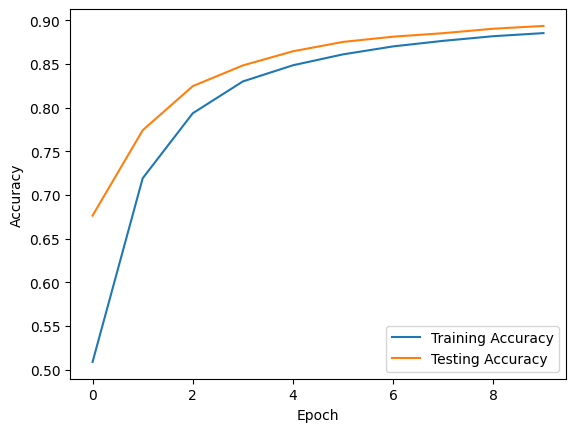

In [44]:
plt.figure()
plt.plot(range(10), accuracies_train, label='Training Accuracy')
plt.plot(range(10), accuracies_test[1:], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 4)
plt.show()

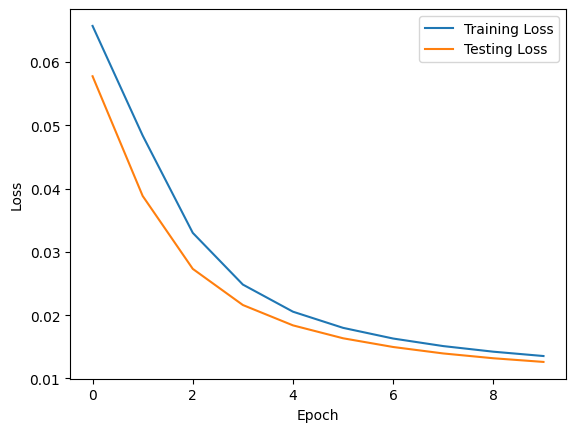

In [45]:
plt.figure()
plt.plot(range(10), losses_train, label='Training Loss')
plt.plot(range(10), losses_test[1:], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 1)
plt.show()

In [46]:
best_acc = accuracies_test.index(max(accuracies_test))
print(f'Best testing accuracy was for {best_acc} epoch: {100*accuracies_test[best_acc]:.2f}%')

Best testing accuracy was for 10 epoch: 89.34%


# Convolutional neural networks

**Convolutional neural networks (CNNs)** are inspired by the structure of the animal visual cortex. Studies demonstrated that numerous neurons in the visual cortex possess a small, localised receptive field, meaning they respond exclusively to visual stimuli within a confined area of the visual field. Let's look at how we can use this fact in image recognition!

The most important part of the CNNs is a **convolutional layer**. A convolutional layer in neural networks is used to extract features from input data (like images) by **applying filters (kernels)**. Each of these filters 'slide' over the input as a 'sliding window', performing element-wise multiplications and summing the results to give an output 'feature'. These operations are linear and hence these are **linear filters**.

The output of all the sliding window applications for a **given filter** is sometimes called a **'convolved feature'** or **'feature map'**, and highlights some important pattern like edges, textures, or shapes in the image. The feature map will have similar dimensions to the original image, depending on the use of padding (if padded appropriate it will have the same dimensions as the original image). Although the convolution operation is linear, this is usually followed by a **nonlinear activation function** application such as ReLU. For ReLU we sometimes call the result a **'rectified convolutional feature map'**.

A convolutional layer **typically applies (independently) multiple filters** (or kernels) to the input, and each filter is designed to detect different features or patterns in the data. **Each filter produces its own feature map**. The result is **multiple feature maps** that are **stacked** together to form the output of the convolutional layer. In contrast to linear layers that require flattening operations, CNNs handle tensor inputs and can simply **return a tensor with an additional dimension representing the number of filters** applied.

Key parameters of a convolutional layer are:

1. Input Channels (in_channels): The number of e.g. colour **channels** in the data. For example, grayscale images have 1 channel, while RGB images have 3 channels.
2. Output Channels (out_channels): The number of **filters** applied by the layer, which determines how many feature maps are produced. Note that each filter produces one feature map by combining the information from all input channels, e.g. a single filter applied to an RGB image would produce a single output feature map. There will be separate weights for each input channel in general, however.
3. Kernel Size (kernel_size): The size of the **filter** (sliding window) (e.g., 3x3, 5x5) that slides across the input. Smaller kernels capture finer details, while larger ones capture more global patterns.
4. Stride (stride): The number of pixels the filter (sliding window) moves at each step. A stride of 1 moves the filter one pixel at a time, while larger strides reduce the resolution of the output feature map.
5. Padding (padding): Adds **extra pixels** around the input to control the (spatial) **size of the output**. Without padding (padding='valid'), the feature map becomes smaller as the filter slides over the input. With padding (padding='same'), the feature map retains the same spatial dimensions as the original input.

Convolutional layers are essential in computer vision because they:

1. Automatically Extract Features: Instead of manually designing features, convolutional layers learn hierarchical patterns (edges, textures, shapes) as filters, enabling networks to detect complex structures in images.
2. Spatial Locality: The filters capture local patterns in an image, making convolution layers highly effective for detecting relevant visual structures.
3. Translation Invariance: Convolutional layers detect features regardless of where they appear in the image, making them robust to shifts and deformations.
4. Parameter Sharing: Each filter is applied across the entire image, reducing the number of parameters and making the model more efficient compared to fully connected layers.


## Creating a convolutional layer
Create the convolutional layer (nn.Conv2D) with one input channel, one filter, a size of kernel $5 \times 5$, stride of 1 in both directions, and padding of 2. After that we will print the initialized weights of this layer. You can access the weights with e.g. `conv_layer.weight`

In [47]:
# Create a single convolutional layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5), stride=(1,1), padding=2)
weights = conv_layer.weight
print(weights)

Parameter containing:
tensor([[[[-0.0588,  0.1288,  0.1712,  0.0879,  0.1168],
          [-0.1218, -0.0625, -0.1189, -0.1913, -0.1391],
          [-0.0906, -0.0974, -0.0965, -0.1554, -0.0624],
          [-0.1860,  0.1522, -0.1046, -0.1058,  0.1038],
          [-0.1239,  0.0192, -0.0878, -0.0473,  0.1415]]]], requires_grad=True)


As you can see, the weights are initialized randomly (just as in nn.Linear()). Let's reinitialize the weights of the convolutional layer as a single $5 \times 5$ horizontal edge detection filter.

Replace the old values in a convolutional layer with a 4D tensor with the new values given in the following cell. We will do this in a torch.no_grad() environment to prevent PyTorch from tracking the weight reinitialization operation in the computation graph. We will use `nn.Parameter` to automatically register the new weights as parameters of the model, meaning they will be included in the model's list of parameters and gradients will be computed during backpropagation.
  

In [48]:
horizontal_filter = torch.tensor([[ -1, -1, -1, -1, -1],
                                  [  0,  0,  0,  0,  0],
                                  [  1,  1,  1,  1,  1],
                                  [  0,  0,  0,  0,  0],
                                  [ -1, -1, -1, -1, -1]],
                                 dtype=torch.float32)

In [49]:
with torch.no_grad():
    conv_layer.weight = nn.Parameter(horizontal_filter.view(1, 1, 5, 5))

Now, apply the horizontal edge detection filter to a first image in a train dataset. And plot the results. You can use `conv_layer(input_image)` to apply the filter

In [50]:
# Example input (1 grayscale image of size 28x28)
input_image, _ =  train_dataset[0] 

# Apply the convolutional layer to the input image
output_image = conv_layer(input_image) 

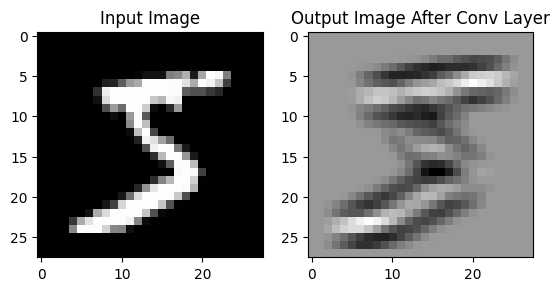

In [51]:
# Convert output to numpy for visualization (squeeze to remove the batch and channel dimensions)
output_image_np = output_image.detach().numpy().squeeze()

# Plot the input and output images
plt.subplot(1, 2, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image_np, cmap='gray')
plt.title('Output Image After Conv Layer')

plt.show()

## Pooling layers
Another important part of CNNs are **pooling** layers. Pooling layers are used in CNNs to reduce the spatial dimensions (height and width) of feature maps while retaining the most important information. This is done to decrease the computational complexity, reduce the number of parameters, and help prevent overfitting.

Pooling operations summarise regions of the feature map into a smaller representation, **effectively downsampling the feature map**. This allows the network to focus on higher-level features as the resolution decreases with each pooling layer.

1. Dimensionality Reduction: Pooling layers downsample the feature maps, reducing the number of parameters and computational load in subsequent layers. This is crucial because deeper layers would otherwise become computationally prohibitive due to the large number of parameters.

2. Translation Invariance: Pooling helps the network become less sensitive to small translations or distortions in the input image. For instance, the position of an object can shift slightly in the image, and pooling helps retain the key features despite those small shifts, making the model more robust.

3. Preventing Overfitting: By reducing the number of parameters, pooling layers reduce the risk of overfitting, especially when the dataset is relatively small.

4. Hierarchical Feature Extraction: Pooling works alongside convolutional layers to allow the network to extract hierarchical features. Early layers might detect edges or textures, while later layers detect more complex features like shapes or objects. Pooling ensures that only the most important features are retained as the network becomes deeper.

The **key parameters of pooling layers are kernel size, stride, padding and type of pooling**. The most used types are **maximum** and **average** pooling. Maximum pooling returns maximum values within the patches of the image, and average pooling returns the mean values within the patches of the image!

It's important to know that pooling layers are **not trainable** as they don't have any learnable parameters.

Create a MaxPool2d layer with a kernel size of 2 and a stride of 2. Apply this layer to the output of horizontal edge detection filter, and plot the results.

In [52]:
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)

maxpooled_image = max_pool_layer(output_image)

In [53]:
print(output_image.shape)
print(maxpooled_image.shape)

torch.Size([1, 28, 28])
torch.Size([1, 14, 14])


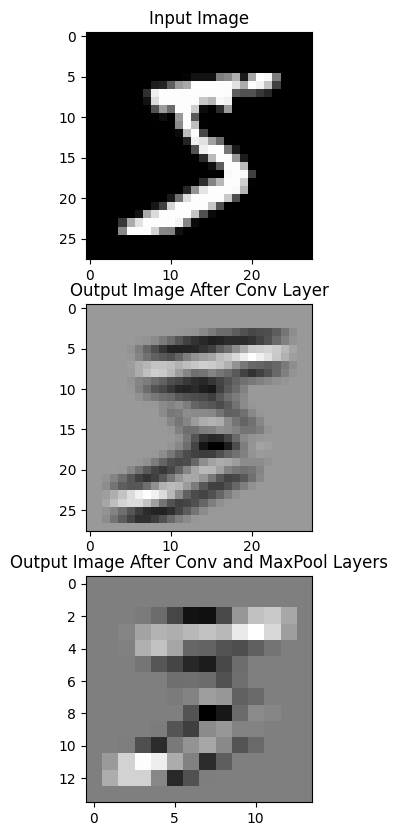

In [54]:
output_image_np = output_image.detach().numpy().squeeze()
maxpooled_image_np = maxpooled_image.detach().numpy().squeeze()

plt.figure(figsize=(10,10))

plt.subplot(3, 1, 1)
plt.imshow(input_image.squeeze().numpy(), cmap='gray')
plt.title('Input Image')

plt.subplot(3, 1, 2)
plt.imshow(output_image_np, cmap='gray')
plt.title('Output Image After Conv Layer')

plt.subplot(3, 1, 3)
plt.imshow(maxpooled_image_np, cmap='gray')
plt.title('Output Image After Conv and MaxPool Layers')

plt.show()

## BEATING THE BASELINE!
Now, you will have **two options**!

The **first** is to **continue** with this notebook and reconstruct the **LeNet-5** architecture, one of the pioneering models in modern computer vision.

The **other** option is to make up **your own/different architecture/hyperparameters** to beat the accuracy of the **baseline** model, i.e. the first simple neural network. Make sure your model doesn't overfit (meaning the performance on the testing dataset is not much worse than for trainset). Good luck!

## LeNet-5
LeNet-5 is one of the earliest and most well-known CNN architectures, developed by Yann LeCun in 1998. It was designed for digit recognition tasks and played a key role in pioneering deep learning, particularly in the field of computer vision.

The architecture is composed of several layers (including convolutional, pooling, and fully connected layers), excluding the input and output layers.

We're going to reconstruct the model from scratch. You will need to insert the required layers with the required parameters just as you did earlier for a simple neural net.

1. First Convolutional Layer: A convolutional layer with 1 input channel, 6 filters (5x5), stride of 1, and padding of 2. Outputs 6 feature maps.

2. Batch Normalisation: Normalises the output of the convolutional layer. BatchNorm2D(input_channels), re-centering and re-scaling it before passing it on.

3. ReLU Activation: Applies non-linearity by replacing negative values with zero.

4. First Max Pooling Layer: A pooling layer with 2x2 window and stride of 2, reducing the feature map size by half.

5. Second Convolutional Layer: A convolutional layer with 6 input channels, 16 filters (5x5), stride of 1, and no padding. Outputs 16 feature maps.

6. Batch Normalization: Normalizes the output of the second convolutional layer. Also needs the input number of channels.

7. ReLU Activation: Again, introduces non-linearity.

8. Second Max Pooling Layer: Another 2x2 pooling layer, reducing the feature map size by half again.

9. Flatten Layer: Converts the feature maps into a 1D vector.

10. First Fully Connected Layer: A fully connected layer with $16 \times 5 \times 5$ and 120 outputs.

11. ReLU Activation: Applies ReLU non-linearity.

12. Second Fully Connected Layer: A fully connected layer with 120 inputs and 84 outputs.

13. ReLU Activation: Applies ReLU again.

14. Final Fully Connected Layer: A fully connected layer with 84 inputs and 10 outputs (for 10 classes).

15. LogSoftmax: Converts the output scores to log-probabilities for classification.

To use GPU runtime, run .to(device).

In [55]:
lenet5 = nn.Sequential(
    # convolutional layer, batch normalisation, ReLU, MaxPool
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1), padding=2),
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),

    # convolutional layer, batch normalisation, ReLU, MaxPool
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=0),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),

    # flatten and then two linear layers
    nn.Flatten(),  # This replaces the reshape operation to flatten the tensor for fully connected layers

    # linear one with relu
    nn.Linear(16*5*5, 120),
    nn.ReLU(),

    # linear two with relu
    nn.Linear(120, 84),
    nn.ReLU(),

    # linear three with log softmax
    nn.Linear(84, 10),
    nn.LogSoftmax(dim=1)
)

lenet5 = lenet5.to(device)

Doublecheck the shape of the output of the Lenet-5 with a random tensor of the (1, 1, 28, 28). Should be the same as the output of the next cell.

In [56]:
input_tensor = torch.randn(1, 1, 28, 28).to(device)
output = lenet5(input_tensor)
print(output.shape)  # Should be (1, 10) if there are 10 output classes

torch.Size([1, 10])


Print the summary of the model. As you might notice, the number of the trainable parameters is almost two times **smaller** than for a "simple" network we used earlier. This is because the *structure* imposed by the convolutional neural network amounts to assuming e.g. some parameters are zero, as well as assuming some parameters are the same as others in the network (parameter sharing) reflecting various forms of invariance assumption.

In [57]:
summary(lenet5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
       BatchNorm2d-2            [-1, 6, 28, 28]              12
              ReLU-3            [-1, 6, 28, 28]               0
         MaxPool2d-4            [-1, 6, 14, 14]               0
            Conv2d-5           [-1, 16, 10, 10]           2,416
       BatchNorm2d-6           [-1, 16, 10, 10]              32
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 5, 5]               0
           Flatten-9                  [-1, 400]               0
           Linear-10                  [-1, 120]          48,120
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                   [-1, 84]               0
           Linear-14                   

Let's use the same loss function, optimizer and learning rate as we did for the simple net.

**Your task** is to train for 10 epochs, output the results, the learning curves and everything of interest!

In [58]:
# Loss function and optimizer
criterion = nn.NLLLoss() # ANSWER
optimizer = optim.SGD(lenet5.parameters(), lr=0.001) 
num_epochs = 10 

losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []

In [59]:
test(lenet5, 0)

Epoch [1/10], Testing loss (per sample): 0.072085


In [60]:
# Training loop
for epoch in range(num_epochs):
    train(lenet5, epoch)
    test(lenet5, epoch)

Epoch [1/10], Training loss per sample: 0.060674
Epoch [1/10], Testing loss (per sample): 0.042475
Epoch [2/10], Training loss per sample: 0.026447
Epoch [2/10], Testing loss (per sample): 0.015359
Epoch [3/10], Training loss per sample: 0.011851
Epoch [3/10], Testing loss (per sample): 0.008528
Epoch [4/10], Training loss per sample: 0.007745
Epoch [4/10], Testing loss (per sample): 0.006168
Epoch [5/10], Training loss per sample: 0.006000
Epoch [5/10], Testing loss (per sample): 0.004965
Epoch [6/10], Training loss per sample: 0.005012
Epoch [6/10], Testing loss (per sample): 0.004173
Epoch [7/10], Training loss per sample: 0.004330
Epoch [7/10], Testing loss (per sample): 0.003687
Epoch [8/10], Training loss per sample: 0.003871
Epoch [8/10], Testing loss (per sample): 0.003359
Epoch [9/10], Training loss per sample: 0.003522
Epoch [9/10], Testing loss (per sample): 0.003036
Epoch [10/10], Training loss per sample: 0.003244
Epoch [10/10], Testing loss (per sample): 0.002811


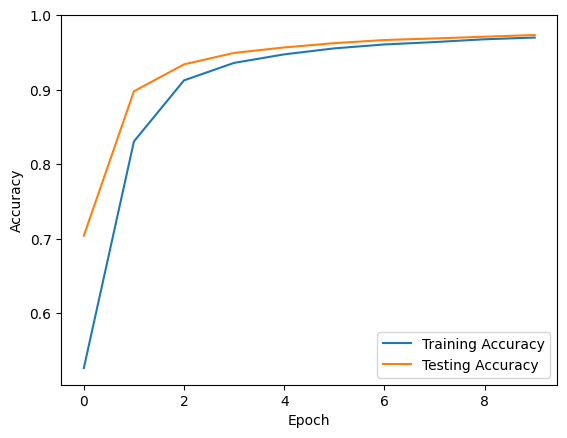

In [61]:
# plot accuracies
plt.figure()
plt.plot(range(10), accuracies_train, label='Training Accuracy')
plt.plot(range(10), accuracies_test[1:], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top=1.0)
plt.legend(loc = 4)
plt.show()

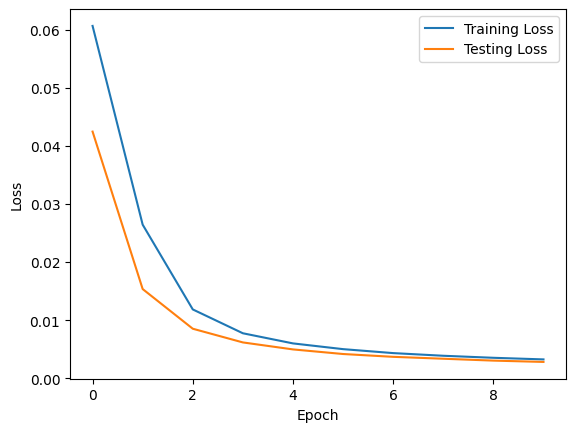

In [62]:
#plot losses
plt.figure()
plt.plot(range(10), losses_train, label='Training Loss')
plt.plot(range(10), losses_test[1:], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 1)
plt.show()

In [63]:
best_acc = accuracies_test.index(max(accuracies_test))
print(f'Best testing accuracy was for {best_acc} epoch: {100*accuracies_test[best_acc]:.2f}%')

Best testing accuracy was for 10 epoch: 97.33%


We can claim the Lenet-5 converges faster and achieves a better accuracy. Woohoo!